## Cel Pracy 

Celem pracy jest stworzenie modelu, który będzie w stanie rozpoznać nieuczciwe transakcje kartami kredytowymi, dzięki czemu klienci instytucji finansowej nie będą obciążani kosztami za rzeczy, których nie kupili.

In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

pd.options.display.float_format = "{:.3f}".format
pd.set_option('display.max_columns',100)

from matplotlib import rcParams
rcParams['figure.figsize'] = 15,6
sns.set(style='white')

In [2]:
def counts_pct(category,data):
    '''Funkcja, która zwraca dla tanej kategori liczbe wartości, oraz wartość procentową'''
    base = data[category].value_counts()
    pct = base/data[category].shape[0] * 100
    joined = pd.concat([base,pct],axis=1)
    joined.columns = [str(category),str(category) + ' %']
    return joined

def annotate(ax,s="%.0f",suffix=''):
    for p in ax.patches:
        ax.annotate(s % p.get_height() + suffix, 
                 (p.get_x() + p.get_width() / 2,
                  p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
        
def despine(rot=0):
    sns.despine(left=True)
    plt.xticks(rotation = rot);
    plt.xlabel('');
    plt.ylabel('');
    
clr = ['#b3b7b8','#c55572']

In [3]:
data = pd.read_csv('creditcard.csv')

In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.099,0.364,0.091,-0.552,-0.618,-0.991,-0.311,1.468,-0.470,0.208,0.026,0.404,0.251,-0.018,0.278,-0.110,0.067,0.129,-0.189,0.134,-0.021,149.620,0
1,0.000,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,0.085,-0.255,-0.167,1.613,1.065,0.489,-0.144,0.636,0.464,-0.115,-0.183,-0.146,-0.069,-0.226,-0.639,0.101,-0.340,0.167,0.126,-0.009,0.015,2.690,0
2,1.000,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,0.248,-1.515,0.208,0.625,0.066,0.717,-0.166,2.346,-2.890,1.110,-0.121,-2.262,0.525,0.248,0.772,0.909,-0.689,-0.328,-0.139,-0.055,-0.060,378.660,0
3,1.000,-0.966,-0.185,1.793,-0.863,-0.010,1.247,0.238,0.377,-1.387,-0.055,-0.226,0.178,0.508,-0.288,-0.631,-1.060,-0.684,1.966,-1.233,-0.208,-0.108,0.005,-0.190,-1.176,0.647,-0.222,0.063,0.061,123.500,0
4,2.000,-1.158,0.878,1.549,0.403,-0.407,0.096,0.593,-0.271,0.818,0.753,-0.823,0.538,1.346,-1.120,0.175,-0.451,-0.237,-0.038,0.803,0.409,-0.009,0.798,-0.137,0.141,-0.206,0.502,0.219,0.215,69.990,0


In [5]:
data.shape

(284807, 31)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [7]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000
mean,94813.860,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,88.350,0.002
std,47488.146,1.959,1.651,1.516,1.416,1.380,1.332,1.237,1.194,1.099,1.089,1.021,0.999,0.995,0.959,0.915,0.876,0.849,0.838,0.814,0.771,0.735,0.726,0.624,0.606,0.521,0.482,0.404,0.330,250.120,0.042
min,0.000,-56.408,-72.716,-48.326,-5.683,-113.743,-26.161,-43.557,-73.217,-13.434,-24.588,-4.797,-18.684,-5.792,-19.214,-4.499,-14.130,-25.163,-9.499,-7.214,-54.498,-34.830,-10.933,-44.808,-2.837,-10.295,-2.605,-22.566,-15.430,0.000,0.000
25%,54201.500,-0.920,-0.599,-0.890,-0.849,-0.692,-0.768,-0.554,-0.209,-0.643,-0.535,-0.762,-0.406,-0.649,-0.426,-0.583,-0.468,-0.484,-0.499,-0.456,-0.212,-0.228,-0.542,-0.162,-0.355,-0.317,-0.327,-0.071,-0.053,5.600,0.000
50%,84692.000,0.018,0.065,0.180,-0.020,-0.054,-0.274,0.040,0.022,-0.051,-0.093,-0.033,0.140,-0.014,0.051,0.048,0.066,-0.066,-0.004,0.004,-0.062,-0.029,0.007,-0.011,0.041,0.017,-0.052,0.001,0.011,22.000,0.000
75%,139320.500,1.316,0.804,1.027,0.743,0.612,0.399,0.570,0.327,0.597,0.454,0.740,0.618,0.663,0.493,0.649,0.523,0.400,0.501,0.459,0.133,0.186,0.529,0.148,0.440,0.351,0.241,0.091,0.078,77.165,0.000
max,172792.000,2.455,22.058,9.383,16.875,34.802,73.302,120.589,20.007,15.595,23.745,12.019,7.848,7.127,10.527,8.878,17.315,9.254,5.041,5.592,39.421,27.203,10.503,22.528,4.585,7.520,3.517,31.612,33.848,25691.160,1.000


### Zbiór Danych

Zbiór danych zawiera informacje o transakcjach dokonane kartami kredytowymi we wrześniu 2013 r. przez europejczyków. Zbiór danych przedstawia transakcje kartami płatniczymi, które miały miejsce w ciągu dwóch dni. Wśród 284 807 transakcji było 492 oszustw. Oznacza to, że jedynie 0.172% wszystkich transakcji to oszustwa.

Zbiór danych zawiera zmienne numeryczne, które są wynikiem transformacji PCA. Dane są poufne dlatego nie mamy informacji co oznaczają poszczególne kolumny. Zmienne przyjmują nazwy V1 - V28. Jedyne cechy, które znamy to data transakcji, wartość transakcji oraz flaga mówiąca czy było oszustwo (1) lub nie było (0) 

Głównym problemem tego zbioru danych jest bardzo nierównomierny. 98.28% naszego zbioru danych to transakcje bez oszustwa, a jedynie 0.172% to transakcje z oszustwem. Jest to bardzo istotne, gdy będziemy tworzyć model predykcyjny. Przy założeniu, że większość naszych transakcji nie jest oszustwem możemy otrzymać fałszywe wnioski. 

PCA (wikipedia) - jedna ze statystycznych metod analizy czynnikowej. Zbiór danych składający się z N obserwacji, z których każda obejmuje K zmiennych, można interpretować jako chmurę N punktów w przestrzeni K-wymiarowej. Celem PCA jest taki obrót układu współrzędnych, aby maksymalizować w pierwszej kolejności wariancję pierwszej współrzędnej, następnie wariancję drugiej współrzędnej itd.. Tak przekształcone wartości współrzędnych nazywane są ładunkami wygenerowanych czynników (składowych głównych). W ten sposób konstruowana jest nowa przestrzeń obserwacji, w której najwięcej zmienności wyjaśniają początkowe czynniki.

__V1 - V28__ - są to nasze cechy, które zostały przetransformowane   
__Amount__ - jest to wartość transakcji  
__Class__ - mówi czy było osztustwo/czy nie było (0/1)  
__Time__ - Liczba sekund pomiędzy pierwszą transakcją z naszego zbioru danych.   

In [8]:
counts_pct(category='Class',data=data)

,Class,Class %
0,284315,99.827
1,492,0.173


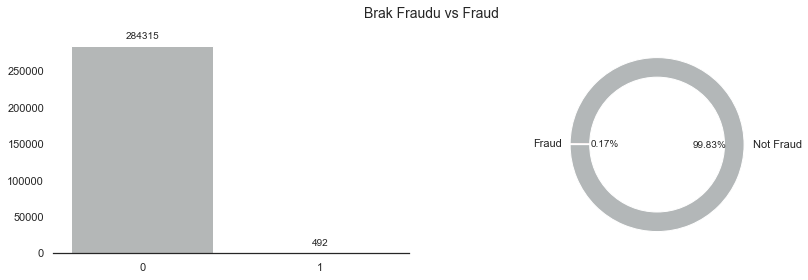

In [9]:
f,ax = plt.subplots(1,2,figsize=(14,4))
b1 = sns.countplot(x=data['Class'],palette=clr,ax=ax[0])
annotate(b1)
despine()
my_circle=plt.Circle( (0,0), 0.775, color='white')
size=data['Class'].value_counts().tolist()
plt.pie(size, labels=['Not Fraud','Fraud'], colors=['#b3b7b8','r'],autopct='%1.2f%%',startangle=180)
p=plt.gcf()
p.gca().add_artist(my_circle);
plt.setp(plt.gcf().get_axes(), xlabel='', ylabel='');
plt.suptitle('Brak Fraudu vs Fraud', fontsize=14);

### Jak poradzić sobie z nierównomiernymi danymi


Czym jest nierównomierna dystrybucja danych ? - Jest to scenariusz, w którym liczba obserwacji należących do jednej klasy jest znacznie niższa niż obserwacji należących do innych klas.

W takich sytuacjach modele predykcyjne stworzone przy użyciu konwencjonalnych algorytmów ML mogą dawać nieprawidłowe wyniki.Dzieje się tak, ponieważ algorytmy ML są zwykle zaprojektowane w celu poprawy dokładności poprzez zmniejszenie błędu jednak nie uwzględniają one rozkładu klas i ich proporcji. 

Istnieją różne podejścia do rozwiązywania problemów związanych z nierównowagą klas. Metody, które są powszechnie używane to metody próbkowania czyli "Sampling Methods". 
Metody te mają na celu zmodyfikowanie niezrównoważonych danych w zrównoważony rozkład za pomocą określonych mechanizmów. Modyfikacja następuje poprzez zmianę rozmiaru oryginalnego zestawu danych w celu zapewnienia lepszego balansu danych. 

Metody stosowane do radzenia sobie z nierównomiernymi danymi:
* Undersampling
* Oversampling
* Synthetic Data Generation
* Cost Sensitive Learning  




__Undersampling__

Ta metoda dotyczy kategorii w której mamy dominującą liczbę obserwacji. Polega na zmniejszeniu liczbę obserwacji z dominującej kategorii tak aby zbiór danych był zrównoważony. Tę metodę najlepiej stosować, gdy zestaw danych jest ogromny, a zmniejszenie liczby próbek treningowych pomaga poprawić czas działania i problemy z pamięcią.
Losowa metoda próbkowania losowo wybiera obserwacje z dominującej kategorii, które są eliminowane do momentu zrównoważenia zestawu danych. Wada - usunięcie obserwacji może spowodować utratę ważnych danych dotyczących klasy większościowej.

__Oversampling__

Ta metoda dotyczy kategorii w której mamy mniejszą liczbę obserwacji. Replikuje obserwacje z klasy mniejszości w celu zrównoważenia danych. Jest również znany jako upsampling. Losowe próbkowanie równoważy dane poprzez losowe nadpróbkowanie klasy mniejszości.  
Zaletą korzystania z tej metody jest brak utraty informacji. Wadą stosowania tej metody jest to, że ponieważ nadpróbkowanie po prostu dodaje replikowane obserwacje w oryginalnym zbiorze danych, kończy się to dodawaniem wielu obserwacji różnych typów, co prowadzi do nadmiernego dopasowania.

__Synthetic Data Generation - Generowanie danych syntetycznych__

Zamiast powielać i dodawać obserwacje z klasy mniejszościowej, pokonuje nierówności poprzez generowanie sztucznych danych. Jest to także rodzaj techniki Oversamplingu.
W odniesieniu do syntetycznego generowania danych, technika nadpróbkowania mniejszości syntetycznych (SMOTE) jest potężną i szeroko stosowaną metodą. Algorytm SMOTE tworzy sztuczne dane w oparciu o podobieństwa przestrzeni cech z próbek mniejszości. Można również powiedzieć, że generuje losowy zestaw obserwacji klasy mniejszościowej, aby przesunąć tendencję uczenia się klasyfikatora do klasy mniejszości.


__Cost Sensitive Learning__  
Jest to kolejna powszechnie stosowana metoda rozwiązywania problemów z klasyfikacją przy niezrównoważonych danych. Metoda ta ocenia koszt związany z błędnymi klasyfikacjami obserwacji. Nie tworzy zrównoważonej dystrybucji danych. Zamiast tego podkreśla problem niezrównoważonego uczenia się poprzez zastosowanie macierzy kosztów, które opisują koszty błędnej klasyfikacji w danym scenariuszu.

więcej: https://www.analyticsvidhya.com/blog/2016/03/practical-guide-deal-imbalanced-classification-problems/

Źródła:  
https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets  
https://medium.com/analytics-vidhya/credit-card-fraud-detection-in-python-using-scikit-learn-f9046a030f50  
https://www.kaggle.com/gargmanish/how-to-handle-imbalance-data-study-in-detail  
https://www.kaggle.com/lct14558/imbalanced-data-why-you-should-not-use-roc-curve  
        
    

#### Macierz  Błędu (Confusion Matrix)
Wybór pomiaru skuteczności modelu jest kluczowym aspektem pracy z niezrównoważonymi danymi. Większość algorytmów klasyfikacji oblicza dokładność na podstawie odsetka prawidłowo sklasyfikowanych obserwacji. W przypadku niezrównoważonych danych wyniki są bardzo mylące, ponieważ klasy mniejszości mają minimalny wpływ na ogólną dokładność.

Confusion Matrix  (macierz błędów) jest stosowana przy ocenie jakości klasyfikacji binarnej (na dwie klasy). Dane oznaczone etykietami: pozytywną i negatywną poddawane są klasyfikacji, która przypisuje im predykowaną klasę pozytywną albo predykowaną klasę negatywną. Możliwa jest sytuacja, że dana oryginalnie oznaczona jako pozytywna zostanie omyłkowo zaklasyfikowana jako negatywną. Wszystkie takie sytuację przedstawia tablica pomyłek.

Różne postacie Confusion Matrix pozwalają łatwiej zaobserwować pewne własności klasyfikacji (np. poniesiony koszt w przypadku błędnej klasyfikacji).
- Postać liczbowa – zawiera liczby obserwacji klasyfikowanych do poszczególnych klas.
- Postać procentowa – zawiera odsetek obserwacji klasyfikowanych do poszczególnych klas wyrażony w procentach 

#### Przykład Macierzy Błędu

![Image of Confusion Matrix](https://www.dataschool.io/content/images/2015/01/confusion_matrix2.png)

- Istnieją dwie możliwe przewidywane klasy: „tak” i „nie”. Gdybyśmy na przykład przewidywali obecność choroby, „tak” oznaczałoby, że chorują, a „nie” oznaczałoby, że nie chorują.
- Klasyfikator dokonał w sumie 165 prognoz (np. 165 pacjentów było testowanych na obecność tej choroby). 
- Z tych 165 przypadków klasyfikator przewidział „tak” 110 razy, a „nie” 55 razy.
- W rzeczywistości 105 pacjentów w próbie ma tę chorobę, a 60 pacjentów nie.


__True positives (TP):__ Są to przypadki, w których przewidzieliśmy "tak" (mają chorobę) i chorują.   
__True negatives (TN):__ Przewidywaliśmy, że "nie", i nie mają choroby.  
__False positives (FP):__ Przewidzieliśmy "tak", ale tak naprawdę nie chorują. („błąd typu I”)  
__False negatives (FN):__ Przewidzieliśmy "nie", ale faktycznie chorują. („błąd typu II”).    


#### Oto lista wskaźników, które często są obliczane z macierzy błędu dla binarnego klasyfikatora:
1. __Accuracy:__ Ogólnie, jak często klasyfikator jest poprawny? __(TP+TN)/total = (100+50)/165 = 0.91__  
2. __Misclassification Rate:__ Ogólnie, jak często klasyfikator jest błędny? __(FP+FN)/total = (10+5)/165 = 0.09__ ("Error Rate")  
3. __True Positive Rate:__ Kiedy "tak" jest pawdziwe, jak często przewiduje "tak"? __TP/actual yes = 100/105 = 0.95__ ("Recall")  
4. __False Positive Rate:__ Kiedy "nie" jest pawdziwe, jak często przewiduje "tak"? __FP/actual no = 10/60 = 0.17__
5. __True Negative Rate:__ Kiedy "nie" jest pawdziwe, jak często przewiduje "nie"? __TN/actual no = 50/60 = 0.83__
6. __Precision:__ Kiedy przewiduje "tak", to jak często jest to prawdziwe? __TP/predicted yes = 100/110 = 0.91__
7. __Prevalence:__ Jak często faktycznie występuje warunek "tak" w naszej próbce? __actual yes/total = 105/165 = 0.64__


__F Score:__ Średnia ważona __True Positive Rate__ (Recall) i __Precision__

więcej: https://pl.wikipedia.org/wiki/Tablica_pomy%C5%82ek

### Eksploracja Danych

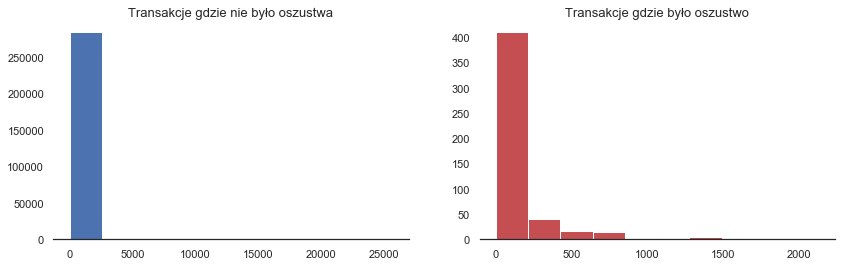

In [10]:
f,ax = plt.subplots(1,2,figsize=(14,4))
h1 = data['Amount'][data.Class == 0].hist(ax=ax[0],grid=False)
h2 = data['Amount'][data.Class == 1].hist(ax=ax[1],grid=False,color='r')
h1.set_title('Transakcje gdzie nie było oszustwa',fontsize=13);
h2.set_title('Transakcje gdzie było oszustwo',fontsize=13);
despine()

In [11]:
# Bez Oszustwa
data['Amount'][data.Class == 0].describe()

count   284315.000
mean        88.291
std        250.105
min          0.000
25%          5.650
50%         22.000
75%         77.050
max      25691.160
Name: Amount, dtype: float64

In [12]:
data['Amount'][data.Class == 0].mode() # Najczęstsza kwota transakcji to 1 dollar

0   1.000
dtype: float64

In [13]:
data['Amount'][data.Class == 0].quantile(0.99) # 99% transakcji gdzie nie było oszustwa ma wartości mniejsze od 1016 

1016.9663999999966

In [14]:
# Oszustwo
data['Amount'][data.Class == 1].describe()

count    492.000
mean     122.211
std      256.683
min        0.000
25%        1.000
50%        9.250
75%      105.890
max     2125.870
Name: Amount, dtype: float64

Widzimy, że nasze dane dotyczące kwoty transakcji gdzie nie mieliśmy doczynienia z oszustwem mają bardzo rozległy rozkład. 
Widzimy, że średnia wartość transakcji gdzie nie mieliśmy oszustwa to 88.29 USD oraz, że wartości transakcji średnio odbiegały od średniej o 250 USD. 75% transakcji miało wartość poniżej 77 USD. 99% transakcji gdzie nie było oszustwa ma wartości mniejsze od 1016. Zobaczmy jak wygląda rozkład w dla tych 99%.
W przypadku naszego zbioru danych, gdzie wystąpiło oszustwo średnia wartość transakcji wynosiła 122 USD i średnio odbiegała od średniej o 256 USD. 75% transakcji było o mniejszej wartości niż 105 USD.

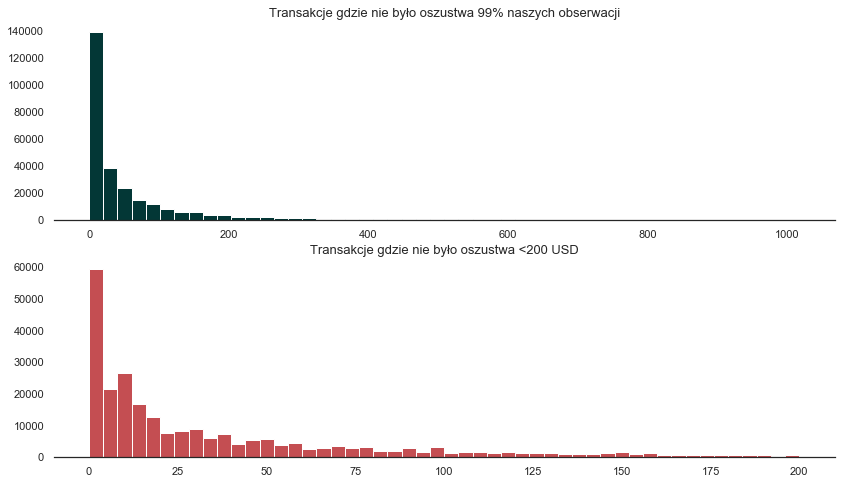

In [15]:
f,ax = plt.subplots(2,1,figsize=(14,8))
h3 = data['Amount'][(data.Class == 0) & (data.Amount < 1017)].hist(grid=False,color='#033736',bins=50,ax=ax[0])
h4 = data['Amount'][(data.Class == 0) & (data.Amount < 200) & (data.Amount > 0 )].hist(grid=False,color='r',bins=50,ax=ax[1])
despine()
h3.set_title('Transakcje gdzie nie było oszustwa 99% naszych obserwacji',fontsize=13);
h4.set_title('Transakcje gdzie nie było oszustwa <200 USD',fontsize=13);

Jak widać większość transakcji gdzie nie było oszustwa to kwoty poniżej 200 USD. Najwięcej w tej grupie stanowiły transakcje poniżej 6 USD

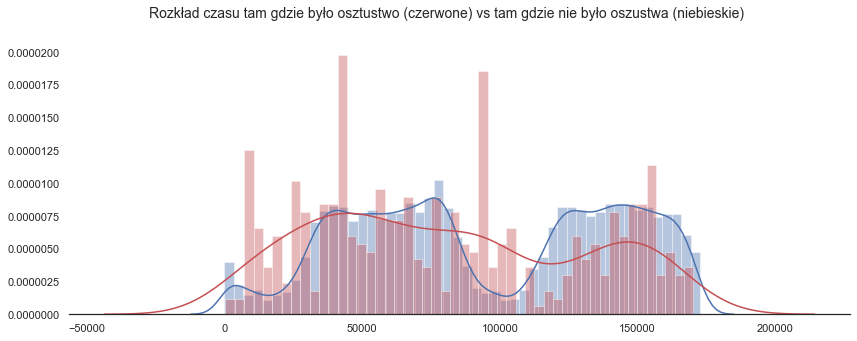

In [16]:
f,ax = plt.subplots(1,1,figsize=(14,5))
h5 = sns.distplot(data['Time'][(data.Class == 0)],color='b',bins=50)
h6 = sns.distplot(data['Time'][(data.Class == 1)],color='r',bins=50)
despine()
plt.suptitle('Rozkład czasu tam gdzie było osztustwo (czerwone) vs tam gdzie nie było oszustwa (niebieskie)',fontsize=14);

### Dystrybucja naszych cech

In [17]:
data.skew().to_frame().T

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.036,-3.281,-4.625,-2.240,0.676,-2.426,1.827,2.554,-8.522,0.555,1.187,0.357,-2.278,0.065,-1.995,-0.308,-1.101,-3.845,-0.260,0.109,-2.037,3.593,-0.213,-5.875,-0.552,-0.416,0.577,-1.170,11.192,16.978,23.998


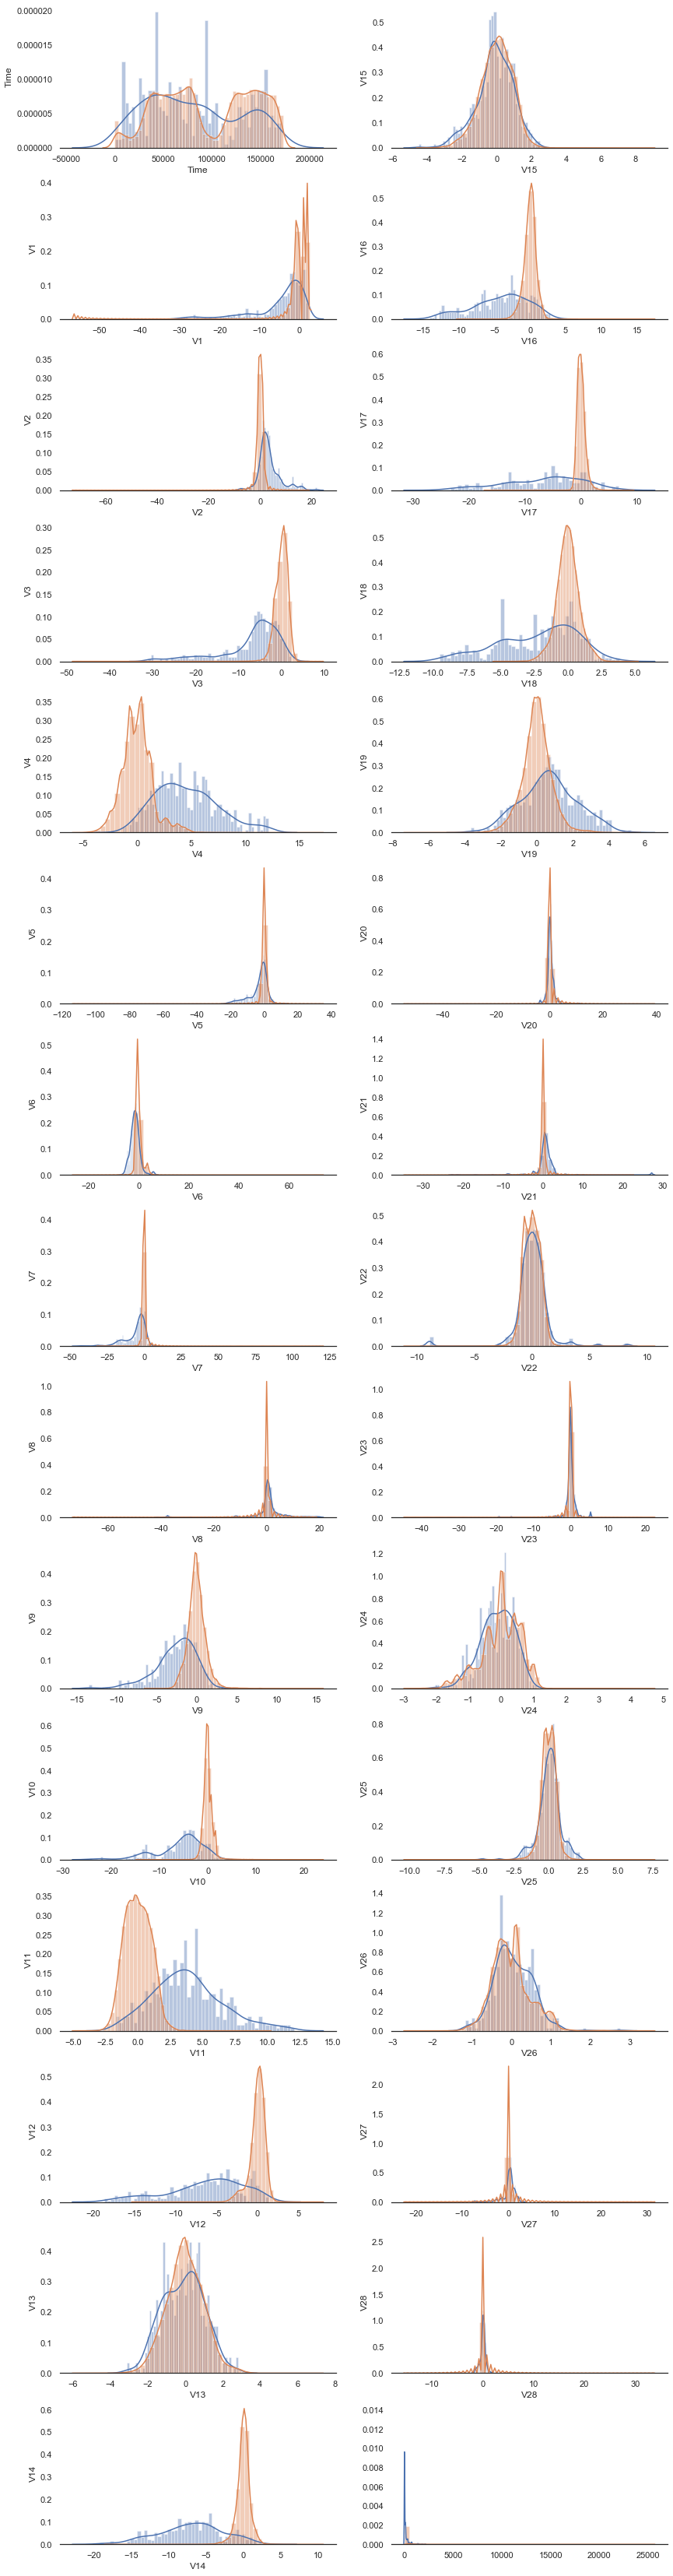

In [18]:
featuresA = data.iloc[:,0:15].columns
featuresB = data.iloc[:,15:30].columns
f,ax = plt.subplots(15,2,figsize=(14,60))
for i, c in enumerate(data[featuresA]):
    a1 = sns.distplot(data[c][data.Class == 1], bins=50,ax = ax[i][0])
    a2 = sns.distplot(data[c][data.Class == 0], bins=50,ax = ax[i][0])
    a1.set_ylabel(f'{c}')
    despine()
for i, c in enumerate(data[featuresB]):
    a3= sns.distplot(data[c][data.Class == 1], bins=50,ax = ax[i][1])
    a4 = sns.distplot(data[c][data.Class == 0], bins=50,ax = ax[i][1])
    a3.set_ylabel(f'{c}')
    despine()

### Macierz Korelacji

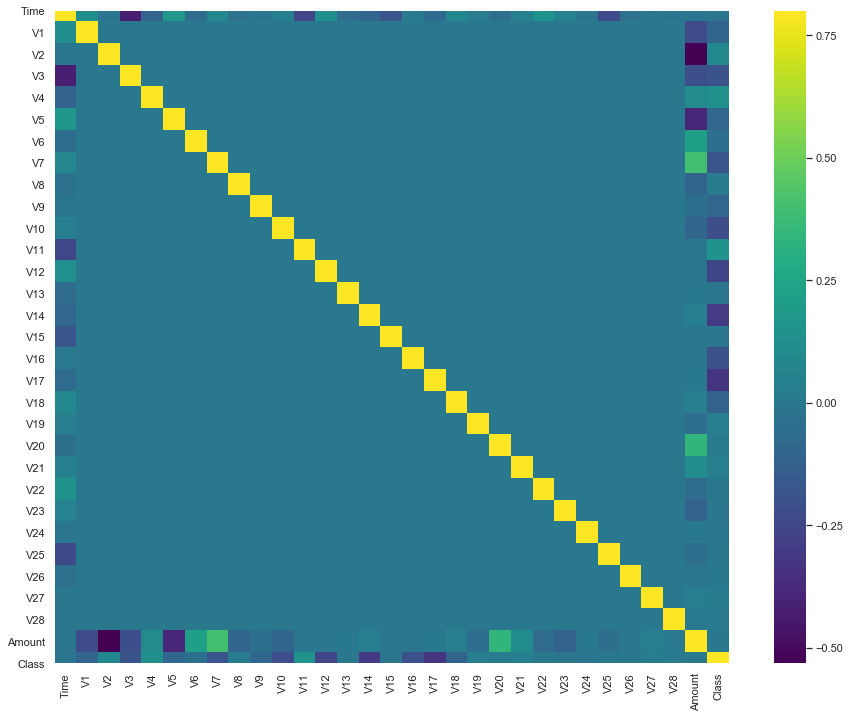

In [19]:
fig = plt.figure(figsize = (16, 12))
sns.heatmap(data.corr(), vmax = .8, square = True,cmap='viridis')
plt.show()

In [20]:
data.corr().unstack().sort_values(ascending=False).drop_duplicates().head(10)

Class   Class   1.000
Amount  V7      0.397
        V20     0.339
        V6      0.216
V5      Time    0.173
V11     Class   0.155
Time    V22     0.144
V4      Class   0.133
V12     Time    0.124
V1      Time    0.117
dtype: float64

In [21]:
data.corr().unstack().sort_values(ascending=True).drop_duplicates().head(10)

V2     Amount   -0.531
V3     Time     -0.420
V5     Amount   -0.386
V17    Class    -0.326
Class  V14      -0.303
V12    Class    -0.261
Time   V11      -0.248
       V25      -0.233
V1     Amount   -0.228
V10    Class    -0.217
dtype: float64

Widzimy, że większość naszych cech nie jest skorelowana. Jedynie wśród macierzy korelacji możemy zauważyć, że istnieje dosyć słaba dodatnia korelacja pomiędzy Amount a V7 i V20. Oraz mamy doczynienia ujemną korelacją w przypadku V2 i Amount, V3 i Time oraz V5 i Amount


Ważne jest, aby nie zapominać, że nasze cechy V1-V28 zostały zeskalowane i wydają się oscylować wokół zera, to nasze cechy takie jak Time i Amount nie zostały zeskalowane. Nie zeskalowanie ich również spowodowałoby, że niektóre algorytmy uczenia maszynowego bazują na nadawaniu wagi cechom (regresja logistyczna) lub polegają na pomiarze odległości (np KNN). 
W celu uniknięcia problemów z tym związanych dokonamy standaryzacji tych 2 cech.

In [22]:
from sklearn.preprocessing import StandardScaler, RobustScaler
scaler = StandardScaler()
robust = RobustScaler()

data['Amount_Scaled'] = robust.fit_transform(data['Amount'].values.reshape(-1,1))
data['Time_Scaled'] = robust.fit_transform(data['Time'].values.reshape(-1,1))
data.drop(['Time','Amount'], axis=1, inplace=True)

Po ustandaryzowaniu naszych cech powinniśmy teraz utworzyć próbkę (sub-sample) naszych danych, żeby mieć równą liczbę przypadków oszustw i braku oszustwa. Pomoże to naszym algorytmom, które wykorzystamy do budowania modelu do lepszego rozpoznania wzorców określających czy transakcja to Fraud czy nie. 

Próbka - w tej analizie jest to tabela danych, która będzie się składać w 50% z transakcji z oszustwem i 50% bez oszustwa. 
Celem utworzenia takiej próbki jest przede wszystkim przeciwdziałanie bardzo dużej dysproporcji danych. Duża dysproporcja w danych powoduje kilka negatywnych zjawisk tj:
- Overfitting - Nasze modele klasyfikacji zakładają, że w większości przypadków nie mamy oszustw
- Błędne korelacje: Chociaż nie wiemy, co oznaczają nasze cechy V1 - V2, przydatne będzie zrozumienie, w jaki sposób każda z tych funkcji wpływa na wynik (oszustwo lub brak oszustwa)

Przed przystąpieniem do techniki "Random UnderSampling" musimy oddzielić oryginalne dane. Później będziemy chcieli przetestować nasze modele na oryginalnym zestawie testowym, a nie na zestawie testowym utworzonym w wyniku Random UnderSamplingu. 


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold, StratifiedKFold

# StratifiedKFold jest używany w celu zapewnienia, że 
# każdy zestaw danych szkoleniowych i walidacyjnych zawiera taki sam odsetek klas 
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False) 


X=data.drop(['Class'], axis=1).values # Nasze cechy
Y=data['Class'].values ## Nasz target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

### Random Under Sampling

Polega na usuwaniu danych w celu uzyskania bardziej zrównoważonego zestawu danych, a tym samym unikaniu nadmiernego dopasowania naszych modeli.

Na początku ustalamy jak niezrównoważone są są nasze dane. Tutaj mamy 492 przypadki oszustw i 284 315 przypadki braku oszustwa.
Po ustaleniu powyższego musimy doprowadzić ilość naszej dominującej klasy do takiej samej ilości jak klasa z oszustwem. 
Czyli powinniśmy mieć 492 przypadki fraudu i 492 przypadków braku fraudu. Po zastosowaniu tej techniki otrzymujemy próbkę naszych danych 50/50 w odniesieniu do naszych klas. Następny krok polega na przetasowaniu danych (shuffle), aby sprawdzić, czy nasze modele mogą zachować określoną dokładność za każdym razem, gdy uruchamiamy skrypt. (Istnieje ogromna utrata informacji w związku z tym że redukujemy 284 315 transakcja bez oszustwa do 492)

In [24]:
data = data.sample(frac=1) # przetasowanie danych
frauds = data.loc[data['Class'] == 1]
nofrauds = data.loc[data['Class'] == 0].head(492)
new_data = pd.concat([frauds, nofrauds])
new_data = new_data.sample(frac=1,random_state=42) # tasowanie

In [25]:
new_data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amount_Scaled,Time_Scaled
192182,2.189,-0.679,-1.325,-0.890,-0.514,-1.216,-0.307,-0.391,-0.639,0.854,-0.240,-0.303,0.608,-0.050,0.295,0.782,0.231,-1.439,0.291,0.036,0.463,1.315,0.052,1.220,0.186,0.007,-0.043,-0.052,0,0.042,0.527
243749,-3.576,3.299,-7.460,7.784,-0.399,-1.968,-3.110,-0.328,-1.574,-2.498,4.604,-9.002,-1.276,-13.969,1.257,-4.492,-5.970,-1.275,1.148,-0.181,0.541,0.720,0.379,-0.617,-0.443,0.360,-2.652,0.422,1,-0.293,0.791
236497,-0.004,0.786,0.345,-0.675,0.379,-0.867,0.876,-0.039,-0.237,-0.227,0.773,0.602,-0.572,0.410,-1.058,0.098,-0.598,-0.225,0.174,-0.063,-0.209,-0.481,0.072,0.058,-0.548,0.117,0.241,0.087,0,-0.276,0.754
70589,-2.043,1.574,-2.373,-0.573,-2.097,-0.174,-3.040,-1.634,-0.595,-5.460,2.379,-2.330,-0.246,-4.059,-0.317,-2.523,-5.603,-0.778,0.860,0.826,-0.723,0.501,-0.697,-0.601,0.128,-0.786,0.606,0.172,1,3.352,-0.361
238366,0.754,2.380,-5.137,3.818,0.043,-1.285,-1.767,0.757,-1.766,-3.263,3.593,-2.772,-0.075,-6.281,0.166,-2.679,-1.386,0.249,2.353,0.370,0.397,0.141,0.172,0.394,-0.445,-0.263,0.305,-0.044,1,-0.279,0.763


In [26]:
counts_pct(category='Class',data=new_data)

,Class,Class %
1,492,50.000
0,492,50.000


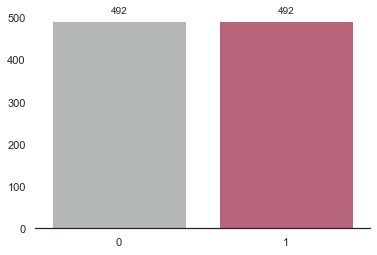

In [27]:
c0 = sns.countplot('Class', data=new_data, palette=clr)
annotate(c0)
despine()

Jak widzimy na powyższym wykresie mamy teraz próbkę danych, która jest zbilansowana i liczba obserwacji dla każdej klasy jest równa.

#### Macierze korelacji
Macierze korelacji są istotą zrozumienia naszych danych. Chcemy wiedzieć, czy istnieją cechy, które mają duży wpływ na to, czy określona transakcja jest oszustwem. Ważne jest jednak, abyśmy używali poprawnej próbki danych, abyśmy mogli zobaczyć, które funkcje mają wysoką dodatnią lub ujemną korelację w odniesieniu do transakcji oszustwa.

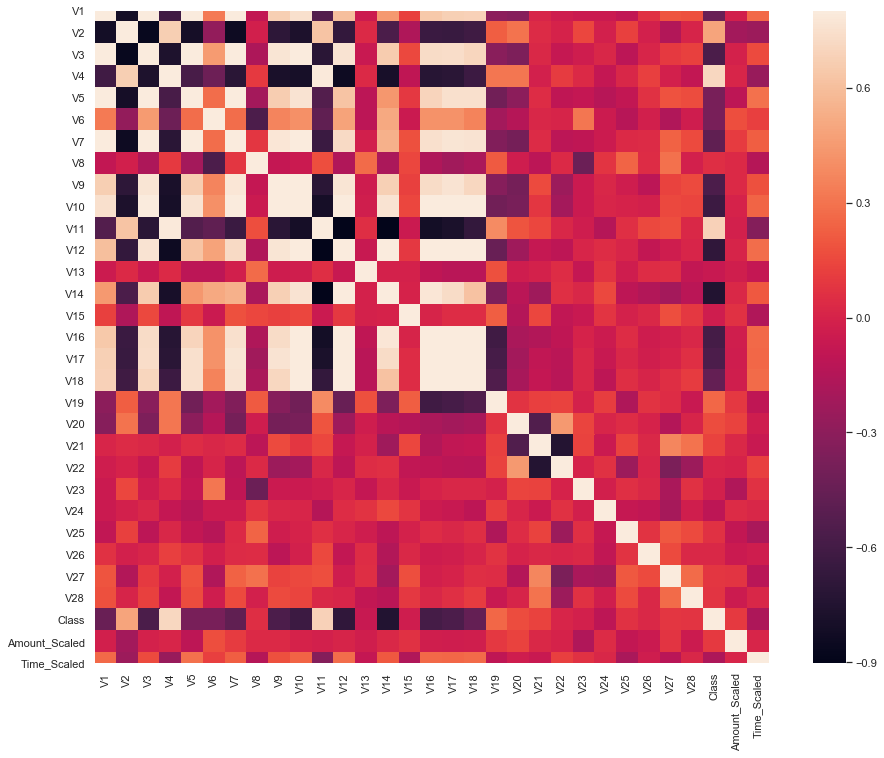

In [28]:
f,ax = plt.subplots(1,1,figsize=(16,12))
sns.heatmap(new_data.corr(),  vmax = .8, square = True)
plt.show()

In [29]:
new_data.corr().unstack().sort_values(ascending=False).drop_duplicates().head(10)

Time_Scaled  Time_Scaled   1.000
V17          V16           0.955
V18          V17           0.939
V16          V18           0.904
V12          V16           0.903
V7           V3            0.891
V1           V7            0.890
V10          V12           0.884
V12          V14           0.880
V1           V3            0.880
dtype: float64

In [30]:
new_data.corr().unstack().sort_values(ascending=True).drop_duplicates().head(10)

V12  V11   -0.902
V11  V14   -0.896
V2   V3    -0.864
V4   V12   -0.842
V2   V7    -0.840
V11  V16   -0.813
V1   V2    -0.813
V10  V11   -0.809
V5   V2    -0.808
V10  V4    -0.800
dtype: float64

In [31]:
new_data.corr()['Class'].to_frame().sort_values(by='Class',ascending=False).head(7)

,Class
Class,1.000
V4,0.712
V11,0.685
V2,0.488
V19,0.259
V20,0.167
V21,0.129


In [32]:
new_data.corr()['Class'].to_frame().sort_values(by='Class',ascending=True).head(5)

,Class
V14,-0.747
V12,-0.685
V10,-0.633
V16,-0.595
V3,-0.564


Teraz możemy zobaczyć jak wyglądają kwestie korelacji dla naszych danych. 

- __V17, V14, V12 i V10, V16__ są ujemnie skorelowane. Im niższe są wartości tych cech, tym bardziej prawdopodobne, że tranakcja jest oszustwem
- __V2, V4, V11__ są dodatnio skorelowane. Im wyższe są wartości tych cech, tym bardziej prawdopodobne, że tranakcja jest oszustwem

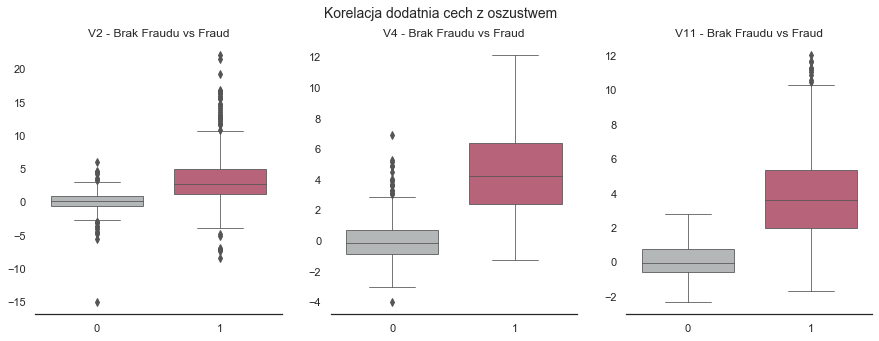

In [33]:
positives = ['V2','V4','V11']

f,ax = plt.subplots(1,3,figsize=(15,5))
f.suptitle('Korelacja dodatnia cech z oszustwem',fontsize=14)
for i,d in enumerate(positives):
    bx = sns.boxplot(x='Class',y=str(d),data=new_data,ax=ax[i],palette=clr,linewidth=0.8,width=0.75)
    bx.set_title(f'{d} - Brak Fraudu vs Fraud');
    bx.set_xlabel('')
    bx.set_ylabel('')
    despine()


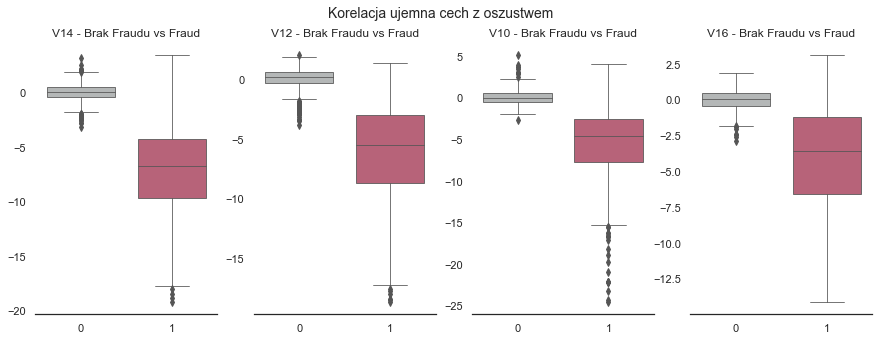

In [34]:
negatives = ['V14', 'V12', 'V10', 'V16']

f,ax = plt.subplots(1,4,figsize=(15,5))
f.suptitle('Korelacja ujemna cech z oszustwem',fontsize=14)
for i,d in enumerate(negatives):
    bx = sns.boxplot(x='Class',y=str(d),data=new_data,ax=ax[i],palette=clr,linewidth=0.8,width=0.75)
    bx.set_title(f'{d} - Brak Fraudu vs Fraud');
    bx.set_xlabel('')
    bx.set_ylabel('')
    despine()

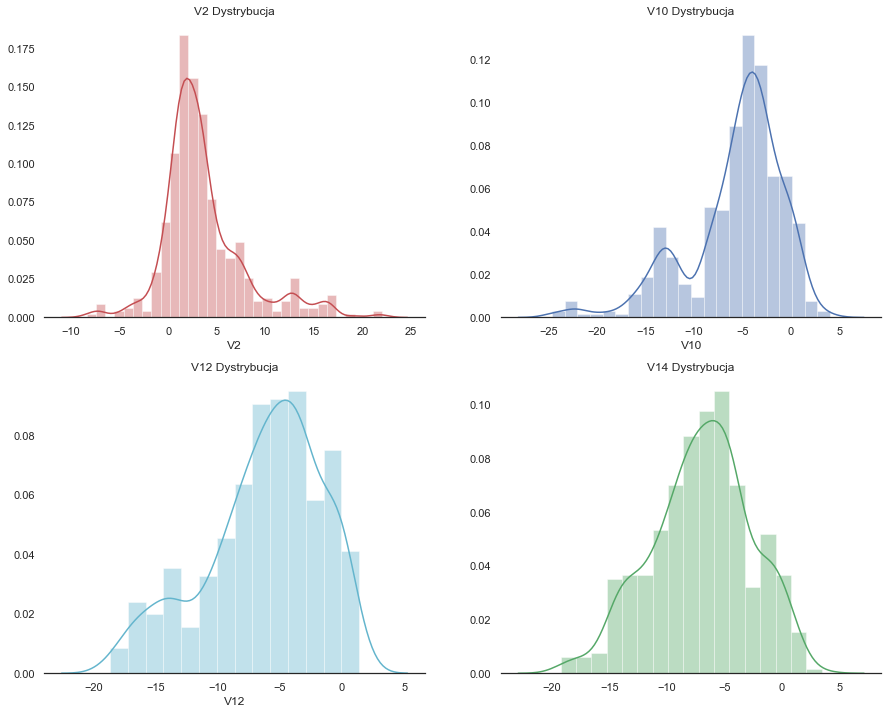

In [35]:
# zobaczmy jak wygląda dystrybucja cech, które w przypadku oszustwa mają nawięcej obserwacji odstających.
# To pomoże nam wyrzucić z modelu obserwacje odstające, które mogą zmniejszyć precyzje naszego modelu. 

f,ax = plt.subplots(2,2,figsize=(15,12))
a = sns.distplot(new_data[new_data['Class']==1]['V2'],ax=ax[0,0],color='r').set_title('V2 Dystrybucja')
b = sns.distplot(new_data[new_data['Class']==1]['V10'],ax=ax[0,1],color='b').set_title('V10 Dystrybucja')
c = sns.distplot(new_data[new_data['Class']==1]['V12'],ax=ax[1,0],color='c').set_title('V12 Dystrybucja')
d = sns.distplot(new_data[new_data['Class']==1]['V14'],ax=ax[1,1],color='g').set_title('V14 Dystrybucja')
despine()

Widzimy, że w przypadku powyższych cech możemy wykryć klilka obserwacji odstających, które mogą nam zaburzyć budowę modelu. 

In [36]:
# Funkcja, tkóra znajduje obserwacje odstające

def outliers(column,data=new_data):
    col_frauds = new_data[column].loc[new_data['Class'] == 1].values
    q1,q3 = np.percentile(col_frauds, 25), np.percentile(col_frauds, 75)
    iqr = q3-q1
    lower,upper = q1 - (iqr * 1.5),q3 + (iqr * 1.5)
    return lower,upper

In [37]:
l0,u0 = outliers(column='V2',data=new_data)
l1,u1 = outliers(column='V10',data=new_data)
l2,u2 = outliers(column='V12',data=new_data)
l3,u3 = outliers(column='V14',data=new_data)

In [38]:
new_data = new_data.drop(new_data[(new_data['V2'] > u0) | (new_data['V2'] < l0)].index)
new_data = new_data.drop(new_data[(new_data['V10'] > u1) | (new_data['V10'] < l1)].index)
new_data = new_data.drop(new_data[(new_data['V12'] > u2) | (new_data['V12'] < l2)].index)
new_data = new_data.drop(new_data[(new_data['V14'] > u3) | (new_data['V14'] < l3)].index)

In [39]:
new_data.shape

(918, 31)

## Redukcja wymiarów i tworzenie klastrów:

### Czym jest redukcja wymiarów ( Dimensionality Reduction )

Praca ze zbiorem danych, który posiada wiele różnych cech, możesz powodować duże trudności przy badaniu relacje jakie zachodzą pomiędzy tymi cechami. Nie tylko utrudnia proces EDA, ale także wpływa na wydajność modelu uczenia maszynowego, ponieważ istnieje wielkie ryzyko, że model będzie zbyt dopasowany (overfit) model lub naruszy niektóre założenia algorytmu, takie jak np. niezależność cech w regresji liniowej. Właśnie tutaj pojawia się redukcja wymiarów.
W uczeniu maszynowym celem redukcji wymiarów jest identyfikacja i eliminacja nieistotnych inadmiarowych informacji w zbiorze danych i pozostawienie w nim wektorów referencyjnych. Zbyt duża ilość zmiennych niesie za sobą ryzyko wzajemnej ich korelacji. A więc informacja wnoszona przez niektóre zmienne może  nie wnosić nowej informacji do analizy, ale powtarzać informacje wniesione już przez inne zmienne. Potrzeba redukcji wymiarowości (redukcji ilości zmiennych) zrodziła całą grupę analiz poświęconej tej kwestii takich jak: analiza czynnikowa, analiza składowych głównych, analiza skupień, czy analiza dyskryminacyjna. Metody te pozwalają na wykrywanie powiązań między zmiennymi. Na podstawie tych powiązań można wyodrębnić grupy podobnych zmiennych, a do dalszych analiz wybrać tylko jednego przedstawiciela każdej grupy (jedną zmienną), albo nową zmienną której wartości są wyliczane w oparciu o pozostałe zmienne w grupie. 

Redukcję wymiarów można osiągnąć na następujące sposoby:

- __Eliminacja cech:__ Ograniczamy przestrzeń cech, eliminując cechy. Ma to jednak wadę, ponieważ tracimy całkowicie informacji zawarte odrzuconych cech.  
- __Wybór cech:__ Stosujemy testy statystyczne, aby uszeregować cechy według ich ważności, a następnie wybieramy podzbiór funkcji do naszego modelu. To również oznacza utratę informacji i jest mniej stabilne, ponieważ inny test nadaje różny stopień ważności cechom.   
- __Wyodrębnianie cech:__ tworzymy nowe niezależne cechy, przy czym każda nowa niezależna cecha jest kombinacją każdej ze starych niezależnych cech.  



__Analiza głównych składników (PCA)__
Analiza głównych składników (PCA) to technika ekstrakcji cech liniowych. Wykonuje liniowe mapowanie danych do przestrzeni o mniejszych wymiarach w taki sposób, aby zmaksymalizować wariancję danych w reprezentacji o małych wymiarach. Czyni to, obliczając wektory własne z macierzy kowariancji. Wektory własne, które odpowiadają największym wartościom własnym (główne składniki), są wykorzystywane do rekonstrukcji znacznej części wariancji oryginalnych danych.
PCA łączy cechy w określony sposób, dzięki czemu możemy odrzucić najmniej ważne elementy cech, zachowując jednocześnie najcenniejsze części wszystkich cech. __Dodatkową korzyścią jest to, że każda z nowych cech lub komponentów utworzonych po PCA jest od siebie niezależna.__  


### t-SNE: (t-Distributed Stochastic Neighbor Embedding)


__t-SNE__ - jest nieliniową techniką zmniejszania wymiarów, która szczególnie dobrze nadaje się do wizualizacji wielowymiarowych zbiorów danych. Jest szeroko stosowana w przetwarzaniu obrazu, NLP, danych genomicznych i przetwarzaniu mowy.   

W skrócie algorytm działa tak:
- Algorytmy zaczynają się od obliczenia prawdopodobieństwa podobieństwa punktów w przestrzeni wielowymiarowej i obliczenia prawdopodobieństwa podobieństwa punktów w odpowiedniej przestrzeni niskiego wymiaru. Podobieństwo punktów oblicza się jako warunkowe prawdopodobieństwo, że punkt A wybierze punkt B jako swojego sąsiada, jeśli sąsiedzi zostaną wybrani proporcjonalnie do ich gęstości prawdopodobieństwa w Gaussa (rozkład normalny) wyśrodkowany na A.  
- Następnie próbuje zminimalizować różnicę między tymi warunkowymi prawdopodobieństwami (lub podobieństwami) w przestrzeni o wyższym i niższym wymiarze, aby uzyskać idealną reprezentację punktów danych w przestrzeni o niższych wymiarach.
- Aby zmierzyć minimalizację sumy różnicy prawdopodobieństwa warunkowego, t-SNE minimalizuje sumę dywergencji Kullbacka-Leiblera całkowitych punktów danych przy użyciu metody spadku gradientowego.

Dywergencja Kullbacka-Leiblera lub dywergencja KL jest miarą tego, jak jeden rozkład prawdopodobieństwa odbiega od drugiego, oczekiwanego rozkładu prawdopodobieństwa.

Mówiąc prościej (t-SNE) minimalizuje rozbieżność między dwoma rozkładami: rozkład, który mierzy podobieństwa par obiektów wejściowych, i rozkład, który mierzy podobieństwa par odpowiednich punktów o małych wymiarach.

Algorytm t-SNE może dość dokładnie grupować przypadki, które w naszym zbiorze danych były oszustwem i brakiem oszustwa.
Mimo, że próbka jest dość mała, algorytm t-SNE jest w stanie dość dokładnie wykrywać klastry w każdym scenariuszu.



więcej: https://towardsdatascience.com/t-sne-python-example-1ded9953f26  
https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1


In [40]:
new_data.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class',
       'Amount_Scaled', 'Time_Scaled'],
      dtype='object')

In [41]:
from sklearn.manifold import TSNE
X = new_data.drop('Class', axis=1)
y = new_data['Class']
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)

In [42]:
X_tsne.shape

(918, 2)

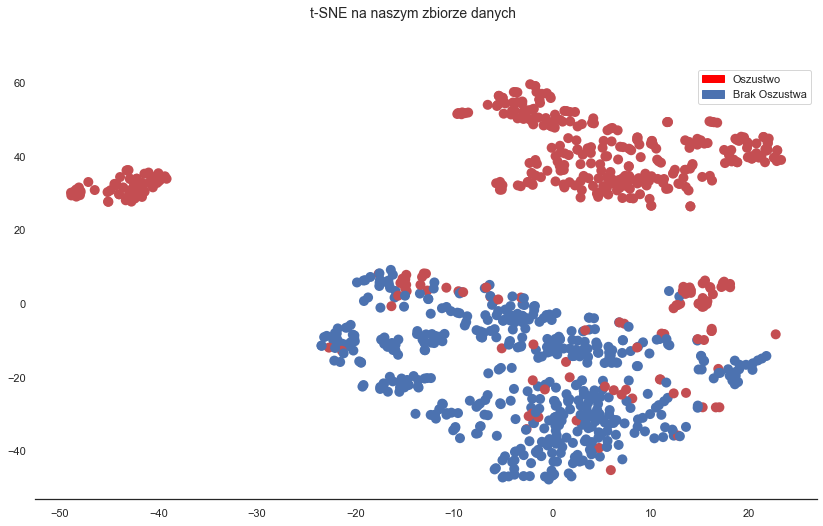

In [43]:
import matplotlib.patches as mpatches # https://matplotlib.org/3.1.1/tutorials/intermediate/legend_guide.html
oszustwa = mpatches.Patch(color='red', label='Oszustwo')
brak_oszustwa = mpatches.Patch(color='b', label='Brak Oszustwa')

f,ax = plt.subplots(1,1,figsize=(14,8))
sns.scatterplot(X_tsne[:,0], X_tsne[:,1], hue=y, legend='full', palette=['b','r'],s=100,linewidth=0,alpha=1)
ax.legend(handles=[oszustwa,brak_oszustwa]);
despine()
plt.suptitle('t-SNE na naszym zbiorze danych',fontsize=14);

Widzimy, że nasz algorytm t-SNE dosyć dobrze sklasyfikował nasze zbiory, choć pozostało kilka obserwacji, które są bardzo zbliżone do siebie pomimo innej klasy.

## Modele Klasyfikacyjne
Użyjemy następujące modele klasyfikacyjne:
- Regresja Logistyczna
- SVC
- Drzewo Decyzyjne
- K najbliższych sąsiadów

### Regresja Logistyczna (Logistic Regression Classifier)

Regresja logistyczna to technika _uczenia statystycznego_ skategoryzowana w metodach „nadzorowanego” uczenia maszynowego (ML) dedykowanych do zadań „klasyfikacji”. Zyskał wysoką popularność i reputację przez ostatnie dwie dekady. Popularność tej metody dotyczy szczególnie sektora finansowego, ze względu na swoją doskonałą zdolność przewidywania, że dany kredytobiorca nie zapłaci przyszłej raty.
Model regresji logistycznej jest szczególnym przypadkiem uogólnionego modelu liniowego. Znajduje zastosowanie, gdy zmienna zależna jest dychotomiczna, to znaczy przyjmuje tylko dwie wartości takie jak na przykład sukces lub porażka, wystąpienie lub brak pewnej jednostki chorobowej, kobieta lub mężczyzna. W zapisie matematycznym wartości te reprezentowane są jako 1 i 0.
Regresja logistyczna to metoda statystyczna służąca do analizy, czy jedna lub więcej zmiennych niezależnych determinuje wynik (w których są tylko dwa możliwe wyniki). Innymi słowy, przewiduje, czy coś jest Prawdą czy Fałszem.
Regresja logistyczna - Jest to algorytm klasyfikacji, który jest używany, gdy zmienna odpowiedzi jest kategoryczna. Ideą regresji logistycznej jest znalezienie związku między cechami a prawdopodobieństwem określonego wyniku.
Na przykład. Kiedy musimy przewidzieć, czy uczeń zda egzamin, czy nie zda egzaminu, gdy podana jest liczba godzin spędzonych na studiowaniu, zmienna odpowiedzi ma dwie wartości: pozytywny i negatywny. 

![Image of LRC](https://miro.medium.com/max/526/1*YLAnZto5ErJZCr45DdgAUA.png)

Powyżej widzimy funkcję Sigmoidalną. Używamy funkcji sigmoidalnej, S (x), ponieważ wynik funkcji wynosi od 0 do 1 (oszacowanie prawdopodobieństwa). Możemy użyć tej funkcji np. do oszacowania prawdopodobieństwa spłaty raty na podstawie określonych cech. Zasadniczo dopasujemy (wytrenujemy) naszą sigmoidalną krzywą do naszego zestawu treningowego i użyjemy modelu, aby dowiedzieć się, czy istnieje prawdopodobieństwo uzyskania określonego wyniku.
Możemy zdecydować, że jeśli prawdopodobieństwo spadnie poniżej 50%, istnieje większe prawdopodobieństwo, że rata zostanie spłacona i vice versa.

więcej https://medium.com/data-science-group-iitr/logistic-regression-simplified-9b4efe801389  
https://medium.com/greyatom/logistic-regression-89e496433063

In [44]:
X = new_data.drop('Class', axis=1).values
y = new_data['Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
model_lr = LogisticRegression(solver='lbfgs') 
model_lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [46]:
cv_score = cross_val_score(model_lr, X_train, y_train, cv=5)

In [47]:
print('Regresja Logistyczna - na tanych testowych skuteczność: ', cv_score.mean())

Regresja Logistyczna - na tanych testowych skuteczność:  0.9454840358949947


#### Znajdywanie najlepszych paramterów modelu 

In [48]:
from sklearn.model_selection import GridSearchCV

In [49]:
param_grid = {"penalty": ['l1','l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_rl = GridSearchCV(LogisticRegression(), param_grid)
grid_rl.fit(X_train, y_train)
log_reg = grid_rl.best_estimator_ ## najlepsze parametry
cv_score_best = cross_val_score(log_reg, X_train, y_train, cv=5)

D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [50]:
print('Regresja Logistyczna - walidacja krzyżowa skuteczność: ', cv_score_best.mean())

Regresja Logistyczna - walidacja krzyżowa skuteczność:  0.9468445801126819


### SVC - Support Vector Classifier

SVC - zapewnia znaczną dokładność przy mniejszej mocy obliczeniowej. Obsługa SVM, może być używana zarówno do zadań regresji, jak i klasyfikacji. Ale model ten jest szeroko stosowany w celach klasyfikacji.
Algorytm SVN ma na celu znalezienie hiperpłaszczyzny w przestrzeni N-wymiarowej (N - liczba elementów), która wyraźnie klasyfikuje punkty danych.
SVC to klasyfikator formalnie zdefiniowany przez oddzielającą hiperpłaszczyznę. Innymi słowy, biorąc pod uwagę oznaczone dane treningowe (uczenie nadzorowane), algorytm generuje optymalną hiperpłaszczyznę, która kategoryzuje nowe przykłady. W dwóch wymiarach przestrzennych hiperpłaszczyzna jest linią dzielącą płaszczyznę na dwie części, gdzie klasy leżą po obu stronach.
Aby oddzielić dwie klasy punktów danych, można wybrać wiele możliwych hiperpłaszczyzn. Naszym celem jest znalezienie płaszczyzny, która ma maksymalny margines, tj. Maksymalną odległość między punktami danych obu klas. Maksymalizacja odległości marginesu zapewnia pewne wzmocnienie, aby przyszłe punkty danych mogły być klasyfikowane z większą pewnością.
![Image of SVC](https://miro.medium.com/max/755/0*ecA4Ls8kBYSM5nza.jpg)

więcej: https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47

In [51]:
model_svc = SVC()
model_svc.fit(X_train, y_train)
cv_score = cross_val_score(model_svc, X_train, y_train, cv=5)
print('SVC - na danych testowych skuteczność: ', cv_score.mean())

SVC - na danych testowych skuteczność:  0.9387091452649182


In [52]:
# najlepsze parametry dla modelu
param_grid = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), param_grid)
grid_svc.fit(X_train, y_train)
svc = grid_svc.best_estimator_

In [53]:
cv_score_best = cross_val_score(svc, X_train, y_train)
print('SVC - walidacja krzyżowa skuteczność: ', cv_score_best.mean())

SVC - walidacja krzyżowa skuteczność:  0.9427673375094408


### Drzewo Decyzyjne


Drzewo decyzyjne to prosta metoda do klasyfikowania przykładów. Jest to nadzorowane uczenie maszynowe, w którym dane są stale dzielone zgodnie z określonym parametrem.
Drzewa decyzyjne są popularną nadzorowaną metodą uczenia się. Zalety drzew decyzyjnych obejmują to, że można ich używać zarówno do regresji, jak i klasyfikacji, są łatwe do interpretacji i nie wymagają skalowania funkcji. Mają kilka wad, w tym podatność na nadmierne dopasowanie.
Drzewo decyzyjne jest strukturą, która może być użyta do podzielenia dużej liczby obserwacji na kolejne mniejsze zbiory poprzez zastosowanie sekwencji prostych reguł decyzyjnych, które można zapisać w formie jeżeli x to 1 w innym wypadku 0. Z każdym kolejnym podziałem, poszczególne grupy stają się coraz bardziej jednorodne ze względu na badane zjawisko, czyli zmienną objaśnianą. Co istotne, wszystkie reguły podziału można zaprezentować w graficznej formie drzewa, co znacznie ułatwia interpretację wyników, a także samego działania algorytmu.
Drzewa klasyfikacyjne są zasadniczo serią pytań zaprojektowanych w celu przypisania klasyfikacji.  

![Image of DT](https://miro.medium.com/max/1098/1*STEB0KajdBmOebaEqwhz1w.png)

więcej: https://towardsdatascience.com/understanding-decision-trees-for-classification-python-9663d683c952  
https://towardsdatascience.com/decision-tree-classification-de64fc4d5aac

Obraz powyżej dotyczy zbioru danych IRIS (gatunkiu kwiatów). Korzeń (brązowy kolor) i gałęzie decyzyjne (niebieski kolor) zawierają pytania, które rozdzielają dane na mniejsze gałęzie. Korzeń jest najwyższym punktem decyzyjnym - w tym miejscu rozpoczyna się drzewo decyzyjne. Liście są najniższymn poziomem (zielony kolor), który już niedzieli się bardziej. Jest to już ostatni etap klasyfikacji.   

Kryterium seleckji: 
- W tej sekcji naprawdę chodzi o zrozumienie, co jest dobrym punktem podziału dla korzeni głównych w drzewach klasyfikacyjnych. Drzewa decyzyjne dzielą się na cechę i odpowiadający jej punkt podziału który daje nam największy przyrost informacji (IG) dla danego kryterium (w tym przykładzie gini lub entropia). Możemy zdefiniować zysk informacji jako __IG = informacja przed podziałem — information po podziale__

In [54]:
model_tree = DecisionTreeClassifier()
model_tree.fit(X_train, y_train)
cv_score = cross_val_score(model_tree, X_train, y_train, cv=5)
print('Drzewo Decyzyjne - na danych testowych skuteczność: ', cv_score.mean())

Drzewo Decyzyjne - na danych testowych skuteczność:  0.9018988935818681


In [55]:
param_grid  = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), param_grid )
grid_tree.fit(X_train, y_train)
tree_best = grid_tree.best_estimator_

In [56]:
cv_score_best = cross_val_score(tree_best, X_train, y_train)
print('Drzewo decyzyjne - walidacja krzyżowa skuteczność: ', cv_score_best.mean())

Drzewo decyzyjne - walidacja krzyżowa skuteczność:  0.9237305077968813


### K najbliższych sąsiadów -  KNeighborsClassifier

KNN - jeden z algorytmow nadzorowanego uczenia maszynowego to taki, który polega na danych wejściowych oznaczonych etykietą w celu nauczenia się funkcji, która wytwarza odpowiednie dane wyjściowe po otrzymaniu nowych nieznakowanych danych.


Metoda K Najbliższych Sąsiadów (k-Nearest Neighbors) należy do grupy algorytmów leniwych (lazy algorithms), czyli takich, które nie tworzą wewnętrznej reprezentacji danych uczących, lecz szukają rozwiązania dopiero w momencie pojawienia się wzorca testującego, np. do klasyfikacji. Przechowuje wszystkie wzorce uczące, względem których wyznacza odległość wzorca testowego.
Algorytm regresji nieparametrycznej używany w statystyce do prognozowania wartości pewnej zmiennej losowej).
Leniwe uczenie oznacza, że ​​algorytm nie dokonuje uogólnień. Oznacza to, że korzystanie z tej metody wymaga niewielkiego szkolenia. Z tego powodu wszystkie dane szkoleniowe są również wykorzystywane do testowania podczas korzystania z KNN.

Algorytm KNN zakłada, że ​​podobne rzeczy istnieją w bliskiej odległości. Innymi słowy, podobne rzeczy są blisko siebie.


KNN jest Nieparametryczny - oznacza, że ​​nie przyjmuje żadnych założeń. Model składa się całkowicie z danych, które są mu przekazywane, zamiast zakładać, że jego struktura jest normalna.

KNN działa z powodu głęboko zakorzenionych teorii matematycznych, których używa. Przy wdrażaniu KNN, pierwszym krokiem jest przekształcenie punktów danych na wektory cech lub ich wartość matematyczną. Algorytm działa następnie poprzez znalezienie odległości między wartościami matematycznymi tych punktów. Najczęstszym sposobem znalezienia tej odległości jest odległość euklidesowa.

![Image of DT](https://miro.medium.com/max/500/0*AXRXmhsvIUvkUpdw)

Zalety KNN:
- Prosty do wdrożenia
- Elastyczny wybór cech / odległości

Wady KNN
- Konieczność ustalenia wartości parametru K (liczba najbliższych sąsiadów)
- Koszt obliczeń jest dość wysoki, ponieważ musimy obliczyć odległość każdego wystąpienia zapytania do wszystkich próbek szkoleniowych.
- metoda jest bardzo czuła na szum w danych treningowych
- Dokładność zależy od jakości danych.


In [57]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)
cv_score = cross_val_score(model_knn, X_train, y_train, cv=5)
print('KNN - na danych testowych skuteczność: ', cv_score.mean())

KNN - na danych testowych skuteczność:  0.9291388676907267


In [58]:
params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_knn = GridSearchCV(KNeighborsClassifier(), params)
grid_knn.fit(X_train, y_train)
# KNears best estimator
knn = grid_knn.best_estimator_

In [59]:
cv_score_best = cross_val_score(knn, X_train, y_train)
print('KNN - walidacja krzyżowa skuteczność: ', cv_score_best.mean())

KNN - walidacja krzyżowa skuteczność:  0.9291283486605358


In [60]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5, method="decision_function")
knears_pred = cross_val_predict(knn, X_train, y_train, cv=5)
svc_pred = cross_val_predict(grid_svc, X_train, y_train, cv=5,method="decision_function")
tree_pred = cross_val_predict(grid_tree, X_train, y_train, cv=5)

#### AUC ROC Score

In [61]:
print('Regresja logistyczna: ', roc_auc_score(y_train, log_reg_pred))
print('K najbliższych sąsiadów ', roc_auc_score(y_train, knears_pred))
print('SVN: ', roc_auc_score(y_train, svc_pred))
print('Drzewo Decyzyjne: ', roc_auc_score(y_train, tree_pred))

Regresja logistyczna:  0.9768488171145938
K najbliższych sąsiadów  0.9323565341755556
SVN:  0.9634854895417436
Drzewo Decyzyjne:  0.9154475299445802


#### Wyniki: 

Patrząc na wyniki możemy zauważyć ,że w przypadku walidacji krzyżowej najlepszą skuteczność miał model 
Regresji Logistycznej - __skuteczność 94.7%__ w przypadku walidacji krzyżowej.  
Regresja logistyczna ma najlepszy wynik w przypadku krzywej (ROC), co oznacza, że regresja logistyczna dość dokładnie oddziela transakcje oszustwa od transakcji niezwiązanych z oszustwem.

Na 2 miejscu pod względem walidacji krzyżowej najlepszą skuteczność miał model  SVC - walidacja krzyżowa skuteczność:  __94.3%__  SVN ma 2 wynik w przypadku krzywej (ROC), co oznacza, że SVN również dość dokładnie oddziela transakcje oszustwa od transakcji niezwiązanych z oszustwem.

Najgorsze wyniki wystąpiły w przypadku Drzewa decyzyjnego - walidacja krzyżowa skuteczność:  92.4%, również w przyadku krzywej ROC wynik był najgorszy z 4 modeli, które omwiałem wyżej.

Jeśli chodzi o porównanie krzywych zestawu treningowego a walidacje krzyżową to można zaznaczyć kilka faktów:  
- Im większa różnica między wynikiem treningu a wynikiem walidacji krzyżowej, tym bardziej prawdopodobne jest, że model jest nadmiernie dopasowany (duża wariancja).
- Jeśli wynik jest niski zarówno w zestawach treningowych, jak i krzyżowych, oznacza to, że model jest niedopasowany
- Klasyfikator regresji logistycznej pokazuje najlepszy wynik zarówno w zestawach treningowych, jak i krzyżowych.

### Regresja Logistyczna - weryfikacja skuteczności przy pomocy macierzy błędów (confussion matrix)

Do oceny naszego modelu wykorzystamy Mcierz Błędu

True positives (TP): Są to przypadki, w których przewidzieliśmy transakcje z oszustwem.  
True negatives (TN): Przewidywaliśmy, że transakcja nie jest oszustwem i jest to prawda.  
False positives (FP): Przewidzieliśmy, że transakcja jest oszustwem a w rzeczywistości nie jest oszustwem  
False negatives (FN): Przewidzieliśmy że transakcja nie jest oszustwem a w rzeczywistości jest oszustwem  

Za dokładność rozpoznania w obrębie klasy odpowiada miara precision.
Za rozpoznanie ilości elementów z klasy odpowiada miara recall.

__Precision:__ True Positives/(True Positives + False Positives)  
__Recall:__ True Positives/(True Positives + False Negatives)  

Precision dla klasy prawdziwej, jest to stosunek poprawnie sklasyfikowanych elementów (True Positives) do (True Positives + False Negatives) - czyli do wiersza, klasy prawdziwej. Analogicznie Precision dla klasy fałszywej, jest to stosunek poprawnie sklasyfikowanych elementów (True Negatives) do (True Negatives + False Positives) - czyli do wiersza, klasy nieprawdziwej

Recall dla klasy Prawdziwej, jest to stosunek poprawnie rozpoznanych elementów (True Positives) do wszystkich, które powinien rozpoznać (True Positives+False Negatives)


F1 score - jest to poprostu średnia harminiczna z Precission i Recall:

Na wysoką dokładność (accuracy) może w dużej mierze przyczynić się duża liczba True Negatives, na których w większości przypadków się zbytnio nie koncentrujemy, podczas gdy False Negatives i False Positives zwykle wiążą się z dużymi kosztami dla danego biznesu. F1 może być lepszą miara do użycia, jeśli musimy szukać pewnej proporcji pomiędzy Precission a Recall oraz mamy dużą dysproporcje w zbiorze danych. 


![Image of DT](https://miro.medium.com/max/282/1*T6kVUKxG_Z4V5Fm1UXhEIw.png)

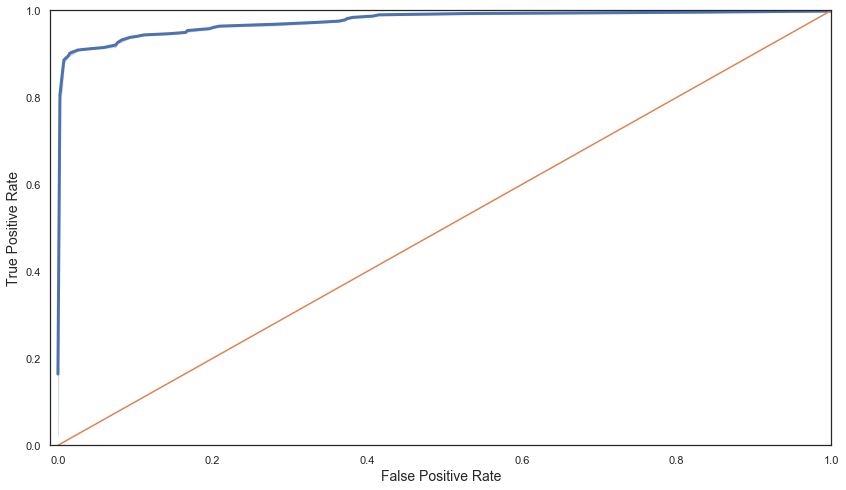

In [74]:
logistic_truefalserate, log_truepositiverate, log_thresold = roc_curve(y_train, log_reg_pred)
f,ax = plt.subplots(figsize=(14,8))
c1 = sns.lineplot(logistic_truefalserate,log_truepositiverate,linewidth=3)
sns.lineplot([0, 1], [0, 1])
c1.set_xlabel('False Positive Rate', fontsize=14)
c1.set_ylabel('True Positive Rate', fontsize=14)
c1.axis([-0.01,1,0,1]);

In [89]:
log_reg = grid_rl.best_estimator_ ## najlepsze parametry
cv_score_best = cross_val_score(log_reg, X_train, y_train, cv=5)
y_pred = log_reg.predict(X_train)
print('Overfitting')
print('Recall: ', recall_score(y_train, y_pred))
print('Precission: ', precision_score(y_train, y_pred))
print('F1 Score: ', f1_score(y_train, y_pred))
print('Accuracy: ', accuracy_score(y_train, y_pred))

Overfitting
Recall:  0.9190751445086706
Precission:  0.9906542056074766
F1 Score:  0.9535232383808097
Accuracy:  0.9577656675749319


### SMOTE Technique (Over-Sampling)